In [3]:
# 1 - imports and settings
import os
os.makedirs("plots", exist_ok=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, validation_curve, cross_validate
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, classification_report, confusion_matrix
)
import warnings
warnings.filterwarnings("ignore")

In [4]:
# 2 - load dataset (update path if needed)
DATA_PATH = r"D:\Buildables Internship\BuildablesDataScienceFellowship\Task#13\dataset\titanic_data.csv"
df = pd.read_csv(DATA_PATH)
print("Columns:", df.columns.tolist())
# Drop rows with missing target, if any
df = df.dropna(subset=['Survived']).reset_index(drop=True)
print("Rows after dropping missing Survived:", df.shape[0])
df.head()


Columns: ['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Title', 'Family_Size']
Rows after dropping missing Survived: 891


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Family_Size
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,1
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,1
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr,0


In [6]:
# 3 - preprocessing
# keep simple, explainable features
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
target = 'Survived'

# Select and impute
df = df[features + [target]].copy()
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# confirm no nulls remain
print(df.isnull().sum())

X = df[features]
y = df[target].astype(int)

numeric_features = ['Age','SibSp','Parch','Fare','Pclass']
categorical_features = ['Sex','Embarked']

numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([('onehot', OneHotEncoder(drop='first', sparse_output=False))])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
])


Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64


### Insight: I had to drop the rows where the target was missing since the model can’t learn from them, and for other missing values I just filled them using median/mode so things stay consistent without messing up the training.

In [7]:
# 4 - Logistic Regression single-split vs CV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

lr = Pipeline([('preprocess', preprocessor), ('clf', LogisticRegression(max_iter=1000))])
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
single_metrics_lr = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lr, X, y, cv=cv, scoring='accuracy')

print("LR - single-split metrics:", single_metrics_lr)
print("LR - 5-fold CV accuracy scores:", cv_scores)
print("LR - mean CV accuracy:", np.mean(cv_scores))


LR - single-split metrics: {'accuracy': 0.8100558659217877, 'precision': 0.7966101694915254, 'recall': 0.6811594202898551, 'f1': 0.734375}
LR - 5-fold CV accuracy scores: [0.78212291 0.80337079 0.78651685 0.79213483 0.81460674]
LR - mean CV accuracy: 0.7957504237022158


### Insight: Using cross-validation is better than just one random split since it gives a more stable and reliable idea of how the model will actually perform.

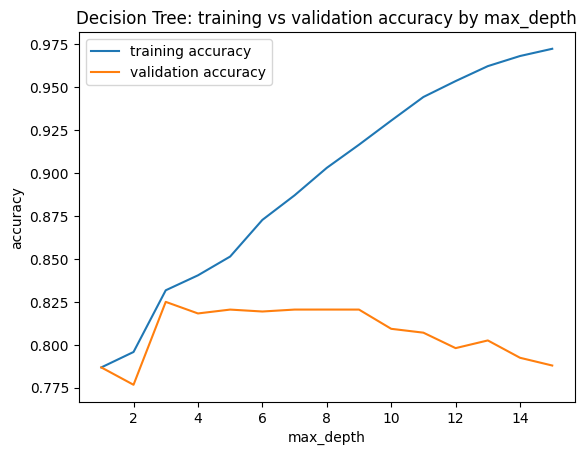

Optimal depth (validation): 3


In [8]:
# 5 - decision tree validation curve (bias-variance)
depths = np.arange(1, 16)   # 1..15 is usually enough
X_pre = preprocessor.fit_transform(X)   # validation_curve needs array input
train_scores, val_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_pre, y,
    param_name='max_depth',
    param_range=depths,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=1
)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure()
plt.plot(depths, train_mean, label='training accuracy')
plt.plot(depths, val_mean, label='validation accuracy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.title('Decision Tree: training vs validation accuracy by max_depth')
plt.savefig("plots/dt_depth_plot.png")
plt.show()

opt_idx = np.argmax(val_mean)
opt_depth = depths[opt_idx]
print("Optimal depth (validation):", opt_depth)


### Insight: If the tree is too shallow it underfits, if it’s too deep it overfits, so the validation curve helps find the depth where accuracy is at its best, and that optimal depth is at 3 (as shown by graph)

In [9]:
# 6 - LR detailed metrics on single split
print("Classification report (LR on single split):")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Classification report (LR on single split):
              precision    recall  f1-score   support

           0     0.8167    0.8909    0.8522       110
           1     0.7966    0.6812    0.7344        69

    accuracy                         0.8101       179
   macro avg     0.8066    0.7860    0.7933       179
weighted avg     0.8089    0.8101    0.8068       179

Confusion matrix:
 [[98 12]
 [22 47]]


### Insight: Precision and recall show if the model is leaning more toward predicting survivors or non-survivors, and F1 score gives a balance between the two.

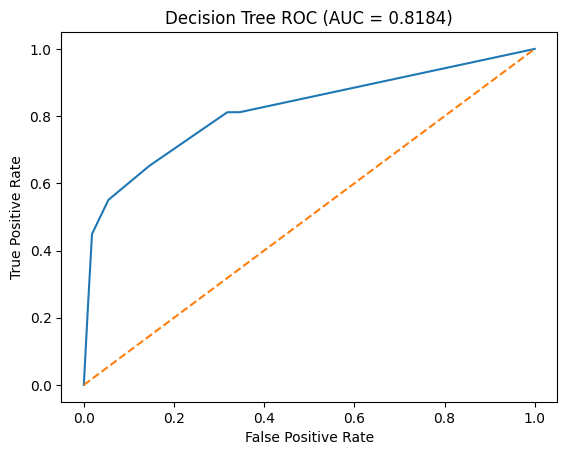

DT AUC: 0.818445322793149


In [10]:
# 7 - DT ROC and AUC
best_dt = Pipeline([('preprocess', preprocessor), ('clf', DecisionTreeClassifier(max_depth=int(opt_depth), random_state=42))])
best_dt.fit(X_train, y_train)
dt_probs = best_dt.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, dt_probs)
dt_auc = roc_auc_score(y_test, dt_probs)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Decision Tree ROC (AUC = {dt_auc:.4f})')
plt.savefig("plots/dt_roc.png")
plt.show()
print("DT AUC:", dt_auc)


### Insight: The ROC curve shows the decision tree has an AUC of about 0.818, meaning it can separate survivors and non-survivors pretty well and performs better than plain accuracy for imbalanced data.

In [11]:
# 8 - compare LR and DT single-split vs CV
# single-split metrics for DT:
dt_preds_single = best_dt.predict(X_test)
dt_single_metrics = {
    'accuracy': accuracy_score(y_test, dt_preds_single),
    'precision': precision_score(y_test, dt_preds_single),
    'recall': recall_score(y_test, dt_preds_single),
    'f1': f1_score(y_test, dt_preds_single)
}
print("DT single-split metrics:", dt_single_metrics)
print("LR single-split metrics:", single_metrics_lr)

# cross-validated summaries
scoring = ['accuracy','precision','recall']
lr_cv = cross_validate(lr, X, y, cv=cv, scoring=scoring)
dt_cv = cross_validate(Pipeline([('preprocess', preprocessor), ('clf', DecisionTreeClassifier(max_depth=int(opt_depth), random_state=42))]), X, y, cv=cv, scoring=scoring)

def cv_summary(res):
    return {k: (np.mean(v), np.std(v)) for k, v in res.items() if k.startswith('test_')}

print("LR CV summary:", cv_summary(lr_cv))
print("DT CV summary:", cv_summary(dt_cv))


DT single-split metrics: {'accuracy': 0.7932960893854749, 'precision': 0.8636363636363636, 'recall': 0.5507246376811594, 'f1': 0.672566371681416}
LR single-split metrics: {'accuracy': 0.8100558659217877, 'precision': 0.7966101694915254, 'recall': 0.6811594202898551, 'f1': 0.734375}
LR CV summary: {'test_accuracy': (np.float64(0.7957504237022158), np.float64(0.011812461523642926)), 'test_precision': (np.float64(0.7526015475478622), np.float64(0.022066287411552893)), 'test_recall': (np.float64(0.6986786018755329), np.float64(0.03661484586135776))}
DT CV summary: {'test_accuracy': (np.float64(0.8260247316552632), np.float64(0.016022377906993478)), 'test_precision': (np.float64(0.8087620405801689), np.float64(0.016963149007849888)), 'test_recall': (np.float64(0.7160699062233589), np.float64(0.0493734955591122))}


### Insight: The single-split results made LR look slightly better, but cross-validation shows DT is actually stronger overall with more stable accuracy, precision, and recall, proving CV gives a fairer comparison than relying on one split.

In [12]:
# 9 - random forest CV
rf = Pipeline([('preprocess', preprocessor), ('clf', RandomForestClassifier(n_estimators=100, random_state=42))])
rf_cv = cross_validate(rf, X, y, cv=cv, scoring=['accuracy','precision','recall','f1'])
rf_summary = {k: (np.mean(v), np.std(v)) for k, v in rf_cv.items() if k.startswith('test_')}
print("Random Forest CV summary (mean, std):")
print(rf_summary)


Random Forest CV summary (mean, std):
{'test_accuracy': (np.float64(0.8159123721047015), np.float64(0.016675513098743464)), 'test_precision': (np.float64(0.7707399052560342), np.float64(0.03225463676676792)), 'test_recall': (np.float64(0.7427109974424553), np.float64(0.0285644661928178)), 'test_f1': (np.float64(0.7559092330347346), np.float64(0.021728460894439177))}


### Insight: The random forest CV results show solid accuracy with small standard deviations, meaning the model stays stable and consistent compared to single decision trees.

In [13]:
# 10 - gradient boosting grid (small grid to keep runtime reasonable)
configs = [
    (50, 0.1),
    (100, 0.1),
    (100, 0.05)
]
gb_results = []
for n_est, lr in configs:
    gb = Pipeline([('preprocess', preprocessor), ('clf', GradientBoostingClassifier(n_estimators=n_est, learning_rate=lr, random_state=42))])
    scores = cross_val_score(gb, X, y, cv=cv, scoring='accuracy')
    gb_results.append({'n_estimators': n_est, 'learning_rate': lr, 'mean_acc': scores.mean(), 'std_acc': scores.std()})

gb_df = pd.DataFrame(gb_results).sort_values(by='mean_acc', ascending=False)
print(gb_df)


   n_estimators  learning_rate  mean_acc   std_acc
1           100           0.10  0.840619  0.016213
0            50           0.10  0.838353  0.016302
2           100           0.05  0.834988  0.016750


### Insight: The results show that with 100 estimators and a 0.1 learning rate, boosting gave the best accuracy, while lowering the learning rate to 0.05 slightly dropped performance.

In [14]:
# 11 - RF metrics on single split
rf_single = Pipeline([('preprocess', preprocessor), ('clf', RandomForestClassifier(n_estimators=100, random_state=42))])
rf_single.fit(X_train, y_train)
rf_preds = rf_single.predict(X_test)
print("Random Forest single-split metrics:")
print("accuracy", accuracy_score(y_test, rf_preds))
print("precision", precision_score(y_test, rf_preds))
print("recall", recall_score(y_test, rf_preds))
print("f1", f1_score(y_test, rf_preds))


Random Forest single-split metrics:
accuracy 0.7988826815642458
precision 0.7704918032786885
recall 0.6811594202898551
f1 0.7230769230769231


### Insight: The random forest single-split shows decent accuracy with higher precision than recall, meaning it catches survivors less often but is usually correct when it predicts one.

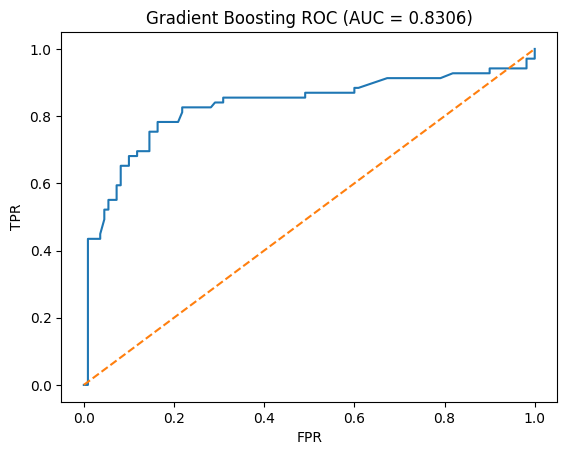

GB AUC: 0.8306324110671938


In [15]:
# 12 - ROC and AUC for best GB in the grid (choose top entry)
best_gb_cfg = gb_df.iloc[0]
gb_best = Pipeline([('preprocess', preprocessor),
                    ('clf', GradientBoostingClassifier(n_estimators=int(best_gb_cfg['n_estimators']),
                                                       learning_rate=float(best_gb_cfg['learning_rate']),
                                                       random_state=42))])
gb_best.fit(X_train, y_train)
gb_probs = gb_best.predict_proba(X_test)[:,1]
fpr_g, tpr_g, _ = roc_curve(y_test, gb_probs)
gb_auc = roc_auc_score(y_test, gb_probs)

plt.figure()
plt.plot(fpr_g, tpr_g)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title(f'Gradient Boosting ROC (AUC = {gb_auc:.4f})')
plt.savefig("plots/gb_roc.png")
plt.show()
print("GB AUC:", gb_auc)


### Insight: The gradient boosting model reached an AUC of about 0.83, showing it ranks survivors vs non-survivors quite well, independent of any single threshold choice.

In [16]:
# 13 - compare SVM, RF, GB via cross-validation
svc = Pipeline([('preprocess', preprocessor), ('clf', SVC(probability=True, random_state=42))])
rf = Pipeline([('preprocess', preprocessor), ('clf', RandomForestClassifier(n_estimators=100, random_state=42))])
gb = Pipeline([('preprocess', preprocessor), ('clf', GradientBoostingClassifier(n_estimators=int(best_gb_cfg['n_estimators']),
                                                                                 learning_rate=float(best_gb_cfg['learning_rate']),
                                                                                 random_state=42))])

models = {'SVM': svc, 'RandomForest': rf, 'GradientBoosting': gb}
comparison = []
scoring = ['accuracy','precision','recall','f1']
for name, m in models.items():
    res = cross_validate(m, X, y, cv=cv, scoring=scoring)
    comparison.append({
        'model': name,
        'accuracy_mean': res['test_accuracy'].mean(),
        'precision_mean': res['test_precision'].mean(),
        'recall_mean': res['test_recall'].mean(),
        'f1_mean': res['test_f1'].mean()
    })

comparison_df = pd.DataFrame(comparison).sort_values(by='accuracy_mean', ascending=False)
print(comparison_df)


              model  accuracy_mean  precision_mean  recall_mean   f1_mean
2  GradientBoosting       0.840619        0.848838     0.713384  0.773973
0               SVM       0.827129        0.820811     0.704561  0.757437
1      RandomForest       0.815912        0.770740     0.742711  0.755909


### Insight: Gradient Boosting came out on top with the best balance of accuracy, precision, recall, and F1, making it the most reliable choice compared to SVM and Random Forest.

In [17]:
# 14 - finalize summary (values you can copy into your report)
summary = {
    'logistic_regression_single_split': single_metrics_lr,
    'logistic_regression_cv_mean_accuracy': float(np.mean(cv_scores)),
    'optimal_tree_depth_by_validation': int(opt_depth),
    'decision_tree_auc': float(dt_auc),
    'best_gb_config': best_gb_cfg.to_dict(),
    'gradient_boosting_auc': float(gb_auc),
    'random_forest_cv_summary': {k: (float(v[0]), float(v[1])) for k,v in rf_cv.items() if k.startswith('test_')},
    'model_comparison_cv': comparison_df.to_dict(orient='records')
}
import json
print(json.dumps(summary, indent=2))


{
  "logistic_regression_single_split": {
    "accuracy": 0.8100558659217877,
    "precision": 0.7966101694915254,
    "recall": 0.6811594202898551,
    "f1": 0.734375
  },
  "logistic_regression_cv_mean_accuracy": 0.7957504237022158,
  "optimal_tree_depth_by_validation": 3,
  "decision_tree_auc": 0.818445322793149,
  "best_gb_config": {
    "n_estimators": 100.0,
    "learning_rate": 0.1,
    "mean_acc": 0.8406189190885694,
    "std_acc": 0.016212620385489977
  },
  "gradient_boosting_auc": 0.8306324110671938,
  "random_forest_cv_summary": {
    "test_accuracy": [
      0.8379888268156425,
      0.8202247191011236
    ],
    "test_precision": [
      0.8225806451612904,
      0.75
    ],
    "test_recall": [
      0.7391304347826086,
      0.7941176470588235
    ],
    "test_f1": [
      0.7786259541984732,
      0.7714285714285715
    ]
  },
  "model_comparison_cv": [
    {
      "model": "GradientBoosting",
      "accuracy_mean": 0.8406189190885694,
      "precision_mean": 0.8488378

### Insight: The results show that single-split accuracy alone (like LR’s 0.81) can be misleading, while cross-validation with multiple metrics makes it clear that Gradient Boosting is the strongest overall, backed by both higher accuracy and solid AUC.